# Part 1: Cellular Automata

In the first part of this tutorial we'll apply the concept of Cellular Automata (CA) to model HIV disease progression in acute phase

### The phenomenon to be modeled and simulated

The immune response to any virus is generated by a complex web of interactions among different types of white blood cells (monocytes, T and B cells). The time scale to develop a specific immune response may vary from days to weeks. In the case of HIV, the entire course of infection involves two different time scales.
The primary infection exhibits the same characteristics as any other viral infection: a dramatic increase of the virus population during the first 2–6 weeks, followed by a sharp decline, due to the action of the immune system. However, instead of being completely eliminated after the primary infection, as many other viruses, a low HIV concentration is detected for a long asymptomatic time: the clinical latency period. This period may vary from one to ten (or more) years. Besides the low virus burden detected during this period, a gradual deterioration of the immune system is manifested by the reduction of CD4+T-cell populations in the peripheral blood. The third phase of the disease is achieved when the concentration of the T cells is lower than a critical value (~30%), leading to the development of AIDS. As a consequence, the patient normally dies from opportunistic diseases.
In this section our aim is to simulate the first phase of HIV infection (acute phase) and show how an arbitrary initial infection in a lattice like cell population can lead in progression of virus within a host body.
- **Reference**: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.87.168102

### Conceptual Model

Let the world be a square $n x n$ grid $G = G(t)$ of cells that evolve over time, which is discrete and measured in weeks.
Every cell of $G$ shows a T-cell which could potentially be in one of the following states:
* **UNINFECTED:** Normal state of T-cell at the beginning of the simulation. This states mean that the cell is uninfected and hence it is in a healthy state.
* **INFECTED:** The T-cell is infected. It takes $\tau$ weeks for the infected T-cell to die.
* **DEAD:** The T-cell is dead at this state. It can be replaced with an uninfected T-cell by immune sytem (with probability $p\_repl$) or remain dead.

Let's associate these states with the following integers:

In [1]:
import numpy as np
import scipy as sc
import scipy.sparse
import random
import matplotlib.pyplot as plt
from ipywidgets import interact


# Possible states:
EMPTY = -1
UNINFECTED = 0
INFECTED = 1
DEAD = 2

The initial configuration is composed of healthy cells, with a small fraction, $p\_HIV$, of infected cells, representing the initial contamination by the HIV.
The follwoing function creates a $(n+2) x (n+2)$ T-cell population lattice with assigning empty to surrounding cells and an initial configuration to the interior cells by randomly assigning INFECTED to  $p\_HIV$ of them and leave rest of them to be equal to UNINFECTED cells.

In [2]:
def GridMap(n, I_fraction):
    """
    Returns an n by n NumPy array of integer values that are empty on the boundary 
    and an initial configuration in interior with some cells marked as infected
    and rest of them marked as uninfected
    
    """
    GM = EMPTY * np.ones(shape=(n+2,n+2), dtype=int)
    GM[1:-1, 1:-1] = UNINFECTED
    num_Infection = int(I_fraction * n * n)
    sequence = [i for i in range(n)]
    idx_row, idx_col = np.zeros(num_Infection), np.zeros(num_Infection)
    for i in range(num_Infection):
        idx_row[i] = random.choice(sequence) + 1
        idx_col[i] = random.choice(sequence) + 1
        
    for i in range(num_Infection):
        GM[int(idx_row[i]), int(idx_col[i])] = INFECTED
        
    return GM

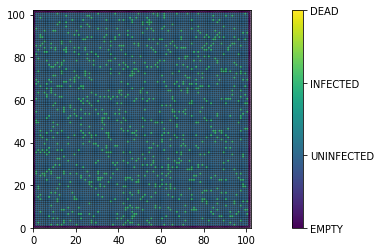

In [3]:
def show_peeps(GM, vmin=EMPTY, vmax=DEAD, values="states"):
    """
    A helper routine to visualize a 2-D world
    """
    assert values in ["states", "bool"]
    if values == "states":
        vticks = range(vmin, vmax+1)
        vlabels = ["EMPTY", "UNINFECTED", "INFECTED", "DEAD"]
    else:
        vticks = [0, 1]
        vlabels = ["False (0)", "True (1)"]
    
    m, n = GM.shape[0]-2, GM.shape[1]-2
    plt.pcolor(GM, vmin=vmin, vmax=vmax, edgecolor='black')
    cb = plt.colorbar()
    cb.set_ticks(vticks)
    cb.set_ticklabels(vlabels)
    plt.axis('square')
    plt.axis([0, m+2, 0, n+2])
    
# Create an initial world
N = 100
p_HIV = 0.1

peeps_0 = GridMap(N, p_HIV)
show_peeps(peeps_0)

Let's define some functions to help us identify uninfected, infected and dead T-cells in our world and calculate the ratio of them with respect to the total number of T-cells in the world

In [4]:
def uninfected(GM):
    """
    Given a grid map, GM, it returns: 
    - a boolean grid whose (i,j) entry equals 1 when GM[i,j] is uninfected and 0 otherwise,
    - ratio of the uninfected cells to total number of cells
    """
    GM_uninfected = (GM==UNINFECTED).astype(int)
    num_uninfected = len(np.where(GM_uninfected)[0])
    ratio = num_uninfected / ((GM.shape[0]-2) * (GM.shape[1]-2))
    return GM_uninfected, ratio

def infected(GM):
    """
    Given a grid map, GM, it returns:
    - a boolean grid whose (i,j) entry equals 1 when GM[i,j] is infected and 0 otherwise,
    - ratio of the infected cells to total number of cells
    """
    GM_infected = (GM==INFECTED).astype(int)
    num_infected = len(np.where(GM_infected)[0])
    ratio = num_infected / ((GM.shape[0]-2) * (GM.shape[1]-2))
    return GM_infected, ratio

def dead(GM):
    """
    Given a grid map, GM, it returns:
    - a boolean grid whose (i,j) entry equals 1 when GM[i,j] is dead and 0 otherwise,
    - ratio of the dead cells to total number of cells
    """
    GM_dead = (GM==DEAD).astype(int)
    num_dead = len(np.where(GM_dead)[0])
    ratio = num_dead / ((GM.shape[0]-2) * (GM.shape[1]-2))
    return GM_dead, ratio

#### Time evolution
Let's define rules which determined how the infection spreads within the host. Each of the time steps used in this simulation is equivalent to a week and includes following:

* **Update of a healthy cell** If it has at least $R$ $(R$ &isin; {$1,2,3,4$}$)$ infected neighbors, it becomes infected. Otherwise, it stays healthy.
* **Update of an infected cell** An infected cell becomes a dead cell after $\tau$ time steps. 
* **Update of a dead cell** A dead cell can be replaced by a healthy cell with probability $p\_repl$ in the next time step. Each healthy cell can get infected again.

To help determine which cells are prone to infection in a given time step, let's write a function to determine who is exposed.

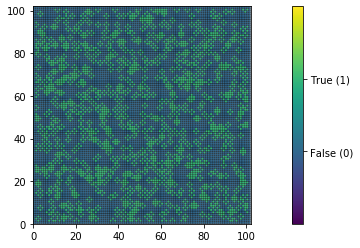

In [5]:
def exposed(GM):
    """
    Given a grid map, GM, returns a boolean grid whose (i,j) entry equals 1 
    when GM[i,j] has at least one infected neighbor, and 0 otherwise.
    """
    E = np.zeros(shape=GM.shape, dtype=int)
    I, _ = infected(GM)
    E[1:-1, 1:-1] = I[0:-2, 1:-1] | I[1:-1, 2:] | I[2:, 1:-1] | I[1:-1, 0:-2]
    return E

show_peeps(exposed(peeps_0), values="bool")

To determine the infected cells in subsequent time step, we need a function to count the number of infected cells surrounding a specific cell. Given this function, we can now determine how the infection spreads in next time step.

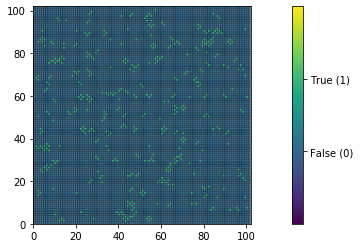

In [6]:
def count_surrounding(GM):
    """
    Given grid map, GM, returns a grid whose (i,j) entry equals
    to the number of infected neighbors for element GM[i,j].
    """
    C = np.zeros(shape=GM.shape, dtype=int)
    I, _ = infected(GM)
    C[1:-1, 1:-1] = I[0:-2, 1:-1] + I[1:-1, 2:] + I[2:, 1:-1] + I[1:-1, 0:-2]
    return C

def spreads(GM, threshold=1):
    """
    Given grid map, GM, returns a boolean grid whose (i,j) entry equals
    to 1 when the cell GM[i,j] has all conditions to get infection in 
    subsequent time step, and 0 otherwise.
    """
    threshold = threshold # minimum number of neighbors needed to infect an uninfected cell
    UI,_ = uninfected(GM)
    G_s = (UI * exposed(GM) * (count_surrounding(GM) > threshold))
    return G_s

show_peeps(spreads(peeps_0), values="bool")

Now we can write a routine to simulate one time step to determine the spread, given grid map GM.

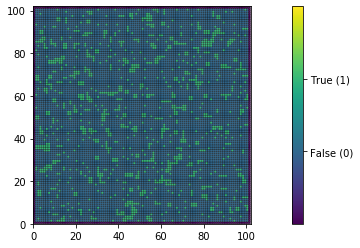

In [7]:
def step_spread(GM):
    """
    Simulates one time step of a SPREAD and 
    returns a grid of the resulting states
    """
    return GM + spreads(GM)

show_peeps(step_spread(peeps_0), values="bool")

Next, we need to implement a function that accounts for death of infected cells in $\tau$ time steps. We also, need a function to replace dead cells with healthy cells after one time step, with some probability. 

In [9]:
def recover(GM, p_repl):
    """
    Given grid map, GM, and replacement probability, p_repl,
    returns a boolean grid whose (i,j) element equals to 0, when 
    the GM[i,j] replaces with a healthy cell, and 1 otherwise.
    Note: 0 selcetd because it'll set the elemnt in GM to UNINFECTED state.
    As such, 1 will leave the GM[i,j] element unchanged.
    """
    random_draw = np.random.uniform(size=GM.shape)
    D, _ = dead(GM)
    G_r = (D * (random_draw < p_repl))
    return (1-G_r).astype(int)

def step_dead(GM, GM_tau, tau):
    """
    Given grid map, GM, and tau grid map history of GM, returns a grid map 
    after replacing infected cells, which were infected in tua steps before, 
    by DEDA state (2). It does not change the status of other cells.
    """
    I = np.ones(GM.shape)
    for i in range(tau):
        I1, _ = infected(GM_tau[i,:,:])
        I = I * I1
    GM_d = GM + I
    return GM_d

It's time to combine all we have together to see what happens when a grid like cell structure gets infected with HIV virus.
In the following, we set the max steps to 100, which shows the maximum number of generations that our simulation will take. Also, we set $\tau=4$, which indicates that it takes 4 time steps (i.e. weeks) for an infected cell to become a dead cell. Finally, we set the probability of cell recovery after its death to $90\%$.

In [10]:
def sim(G_0, max_steps=100, tau=4, p_repl=0.90):
    """
    Given an initial grid map, G_0, returns max_steps generations of HIV spread
    
    tau: represents the time required for the immune system to 
    develop a specific response to kill an infected cell
    p_repl: probability by which dead cells could be replaced with healthy cells
    """
    # In the first tau steps, there will only be spread (no dead cells):
    G_null = GridMap(G_0.shape[0]-2, 0)
    G_all = np.repeat(G_null[np.newaxis,:,:], max_steps, axis=0)
    G_all[0,:,:] = step_spread(G_0)
    for idx in range(1,tau):
        G_all[idx,:,:] = step_spread(G_all[idx-1,:,:])
    
    # Infected cells will die in tau step and immune system will recover them with probability p_repl:
    _, infected_ratio = infected(G_all[tau-1,:,:])
    t = tau
    while(infected_ratio > 0) and (t < max_steps):
        G_t = step_spread(G_all[t-1,:,:]) # spread the virus
        G_t = G_t * recover(G_t, p_repl) # recover dead cells with p_prepl probability
        G_t = step_dead(G_t, G_all[t-tau:t,:,:], tau) # tau-step before infected cells become dead cells
        G_all[t,:,:] = G_t # store the result
        
        # Update the stop criterion
        _, infected_ratio = infected(G_t)
        t = t + 1
        
    return G_all

test = sim(peeps_0)

Text(0, 0.5, 'Density')

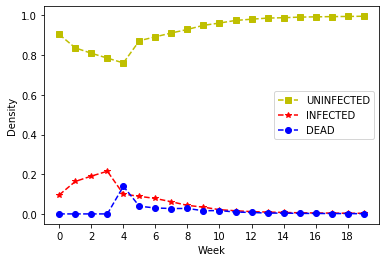

In [13]:
def compute_ratio(G_0, GM_all):
    """
    Given initial configuraion and all generations of spread,
    returns three matrices, which shows uninfected cell ratio, 
    infected cell ratio and dead cell ratio to the total number 
    of cells, respectively.
    """
    uninfected_ratio = np.zeros(GM_all.shape[0]+1)
    infected_ratio = np.zeros(GM_all.shape[0]+1)
    dead_ratio = np.zeros(GM_all.shape[0]+1)
    
    _, uninfected_ratio[0] = uninfected(G_0)
    _, infected_ratio[0] = infected(G_0)
    _, dead_ratio[0] = dead(G_0)
    
    for i in range(1, GM_all.shape[0]):
        _, uninfected_ratio[i] = uninfected(GM_all[i,:,:])
        _, infected_ratio[i] = infected(GM_all[i,:,:])
        _, dead_ratio[i] = dead(GM_all[i,:,:])
        
        
    return uninfected_ratio, infected_ratio, dead_ratio

UR, IR, DR = compute_ratio(peeps_0, test)
plt.plot(UR[:20], 'ys--')
plt.plot(IR[:20], 'r*--')
plt.plot(DR[:20], 'bo--')
plt.legend(['UNINFECTED', 'INFECTED', 'DEAD'])
plt.xticks(np.arange(0, 20, step=2))
plt.xlabel('Week')
plt.ylabel('Density')

In [12]:
def isim(N, p_HIV, max_steps=100, tau=4, p_repl=0.9, plot_to=20):
    G_0 = GridMap(N, p_HIV)
    G_t = sim(G_0, max_steps=max_steps, tau=tau, p_repl=p_repl)
    UR, IR, DR = compute_ratio(G_0, G_t)
    plt.plot(UR[:plot_to], 'ys--')
    plt.plot(IR[:plot_to], 'r*--')
    plt.plot(DR[:plot_to], 'bo--')
    plt.legend(['UNINFECTED', 'INFECTED', 'DEAD'])
    plt.xticks(np.arange(0, plot_to, step=2))
    plt.xlabel('Week')
    plt.ylabel('Density')
    
interact(isim,
        N = (10,100,10),
        p_HIV = (0.1,0.9,0.1),
        max_steps = (20,1000,2),
        tau = (1,6,1),
        p_repl = (0,1,0.1),
        plot_to = (10,100,10));
    

interactive(children=(IntSlider(value=50, description='N', min=10, step=10), FloatSlider(value=0.5, descriptio…

The following shows the simulation from the reference paper which is very similar to our simulations. Note that, in this section, we aimed just to simulate the behavior after weeks of infection and hence our simulations should reflect the behavior of left figure in the following. 

<img src="paper%20simulation.png" alt="Drawing" style="width: 500px;"/>

- **Reference**: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.87.168102